# План проекта

1. Исследование данных: 
   - загрузка данных
   - исследование каждого датафрейма
2. Предобработка данных:
   - обработка пропусков и аномалий
   - агрегирование по ключу
   - добавление новых признаков
   - выбрать необходимые признаки и объединить их в одну таблицу
   - исследование объединенного датафрейма
   - разденение на выборки и масштабирование
   - проверям корреляцию данных
3. Разработка модели:
   - выбор моделей регресии
   - подбор гиперпараметров, получение метрики на кросс-валидации
   - выбор лучшей модели
   - проверка качества лучшей модели на тестовой выборке
   - сравнение с константной моделью
   - исследование важности признаков
4. Отчет

## 1. Первичный анализ данных

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.dummy import DummyRegressor
warnings.filterwarnings("ignore")

In [3]:
data_arc = pd.read_csv('data_arc_new.csv')
data_bulk = pd.read_csv('data_bulk_new.csv')
data_bulk_time = pd.read_csv('data_bulk_time_new.csv')
data_gas = pd.read_csv('data_gas_new.csv')
data_temp = pd.read_csv('data_temp_new.csv')
data_wire = pd.read_csv('data_wire_new.csv')
data_wire_time = pd.read_csv('data_wire_time_new.csv')

### 1.1 Данные об электродах

In [4]:
data_arc.head(7)

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   
5    2  2019-05-03 11:34:14  2019-05-03 11:36:31           0.381124   
6    2  2019-05-03 11:38:50  2019-05-03 11:44:28           0.261665   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
5             0.220351  
6             0.205527

In [5]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc.shape

(14876, 5)

In [7]:
data_arc.describe()

key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284

In [8]:
data_arc[data_arc['Реактивная мощность'] <=0]

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57           0.705344   

      Реактивная мощность  
9780          -715.479924

**Вывод**

Пропусков в данных нет. В столбце "Реактивная мощность" есть 1 аномалия. Можно удалить всю партию с этой аномалией или восстановить данные по активной мощности. 

В качестве признаков можно добавить длительность нагрева и полную мощность. Данные по партиям следует объединить и добавить признак: количесво циклов каждой партии. Так же можно добавить в качестве признака - энергию, как произведение мощности на время.

### 1.2 Данные о подаче сыпучих материалов (объем) 

In [9]:
data_bulk.head(7)

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   
5    6     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   
6    7     NaN     NaN     NaN   117.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  
5     NaN      NaN      NaN    204.0      NaN    201.0    154.0  
6     NaN      NaN      NaN    204.0      NaN    152.0    154.0

In [10]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [11]:
data_bulk.shape

(3129, 16)

In [12]:
data_bulk.describe()

key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk 5      Bulk 6      Bulk 7  Bulk 8      Bulk 9     Bulk 10  \
count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
min     11.000000   17.000000   47.000000    49.0   63.000000   24.000000   
25%     70.000000   69.750000  155.000000    49.0   66.000000   64.000000   
50%     86.000000  100.000000  298.000000    49.0   68.000000   86.500000   
75%    132.000000  157.000000  406.000000    49.0   70.500000  102.000000   
max    603.000000  503.000000  772.000000    49.0  147.000000  159.000000   

          Bulk 11      Bulk 12     Bulk 13      Bulk 14      Bulk 15  
count  177.000000  2450.000000   18.000000  2806.000000  2248.000000  
mean    76.819209   260.471020  181.111111   170.284747   160.513345  
std     59.655365   120.649269   46.088009    65.868652    51.765319  
min      8.000000    53.000000  151.000000    16.000000     1.000000  
25%     25.000000   204.000000  153.250000   119.000000   105.000000  
50%     64.000000   208.000000  155.500000   151.000000   160.000000  
75%    106.000000   316.000000  203.500000   205.750000   205.000000  
max    313.000000  1849.000000  305.000000   636.000000   405.000000

In [13]:
data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

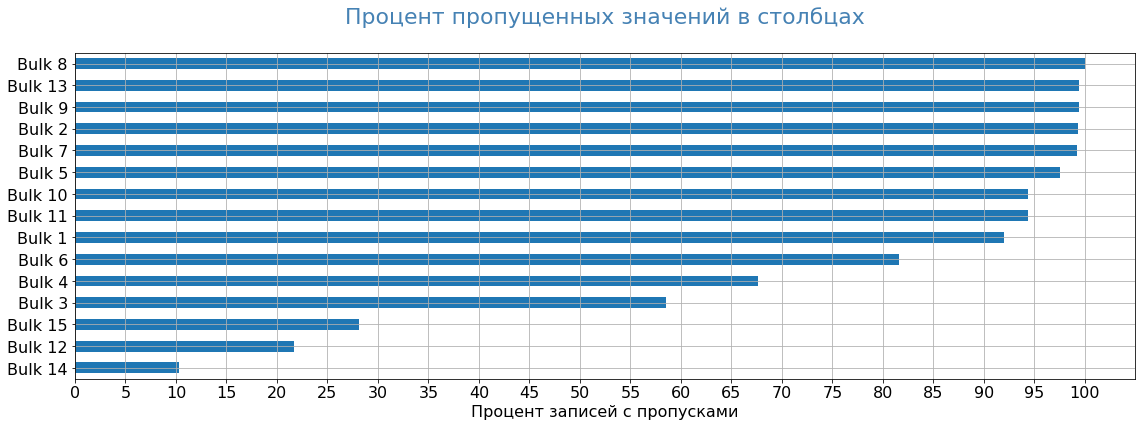

In [14]:
(data_bulk.isna().mean()*100)\
.to_frame()\
.rename(columns = {0:'space'})\
.query('space > 0')\
.sort_values(by = 'space', ascending = True)\
.plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16, grid=True)\
.set_title('Процент пропущенных значений в столбцах' + "\n", fontsize = 22, color = 'SteelBlue')
plt.xticks(range(0,105,5))
plt.xlabel('Процент записей с пропусками', fontsize=16);

**Вывод**

В данных о подаче сыпучих материалов много пропусков. Те столбцы, где пропусков более 95 проентов следует удалить. Остальные пропуски заполним нулями.

### 1.3 Данные о подачи сыпучих материалов (время)

In [15]:
data_bulk_time.head(7)

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   
5    6    NaN    NaN    NaN  2019-05-03 13:57:27    NaN    NaN    NaN    NaN   
6    7    NaN    NaN    NaN  2019-05-03 14:18:58    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   
5    NaN     NaN     NaN  2019-05-03 13:48:52     NaN  2019-05-03 14:09:42   
6    NaN     NaN     NaN  2019-05-03 14:41:26     NaN  2019-05-03 14:30:50   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47  
5  2019-05-03 14:03:15  
6  2019-05-03 14:27:16

In [16]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [17]:
data_bulk_time.shape

(3129, 16)

In [18]:
data_bulk_time.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

**Вывод**

Пропусков очень много, как и в объемах сыпучих материалах, что логично, потому что пропуски означают, что материалы не использовали. Время подачи сыпучих материалов не поможет нам в постоении моделей, эти данные не будут отнесены в признаки.

### 1.4 Данные о продувке сплава газом

In [19]:
data_gas.head(7)

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692
5    6  11.273392
6    7   9.836267

In [20]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [21]:
data_gas.shape

(3239, 2)

In [22]:
data_gas.describe()

key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

In [23]:
data_gas.isna().sum()

key      0
Газ 1    0
dtype: int64

**Вывод**

Пропусков в данных нет. Очевидных выбросов нет. Все данные можно использовать для построения модели.

### 1.5 Результаты измерения температуры

In [24]:
data_temp.head(7)

key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0
5    1  2019-05-03 11:30:38       1613.0
6    2  2019-05-03 11:34:04       1581.0

In [25]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [26]:
data_temp.shape

(18092, 3)

In [27]:
data_temp.describe()

key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385     20.394381
min        1.000000   1191.000000
25%      807.750000   1580.000000
50%     1618.000000   1590.000000
75%     2429.000000   1599.000000
max     3241.000000   1705.000000

In [28]:
data_temp.isna().sum()

key                0
Время замера       0
Температура     3427
dtype: int64

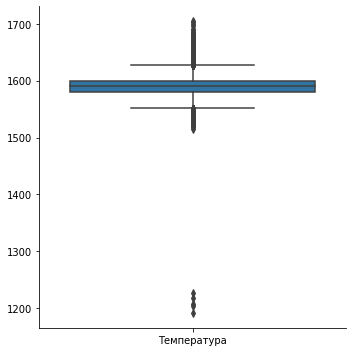

In [29]:
sns.catplot(kind="box", data=data_temp[['Температура']])
plt.show()

**Вывод**

Есть пропуски в данных, есть явные аномалии. Необходимо удалить все партии, где значение температуры менее 1450 градусов, а так же парти, где отсутвует температура. Первое значение температуры в каждой партии будет являться признаком, последнее - целевым признаком.

### 1.6 Данные о проволочных материалах (объем)

In [30]:
data_wire.head(7)

key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   
5    6  99.109917  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   
6    7  98.061600      NaN     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
5     NaN  
6     NaN

In [31]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [32]:
data_wire.shape

(3081, 10)

In [33]:
data_wire.describe()

key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire 9  
count   73.000000  11.000000   19.000000  29.000000  
mean    48.016974  10.039007   53.625193  34.155752  
std     33.919845   8.610584   16.881728  19.931616  
min      0.034320   0.234208   45.076721   4.622800  
25%     25.053600   6.762756   46.094879  22.058401  
50%     42.076324   9.017009   46.279999  30.066399  
75%     64.212723  11.886057   48.089603  43.862003  
max    180.454575  32.847674  102.762401  90.053604

In [34]:
data_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

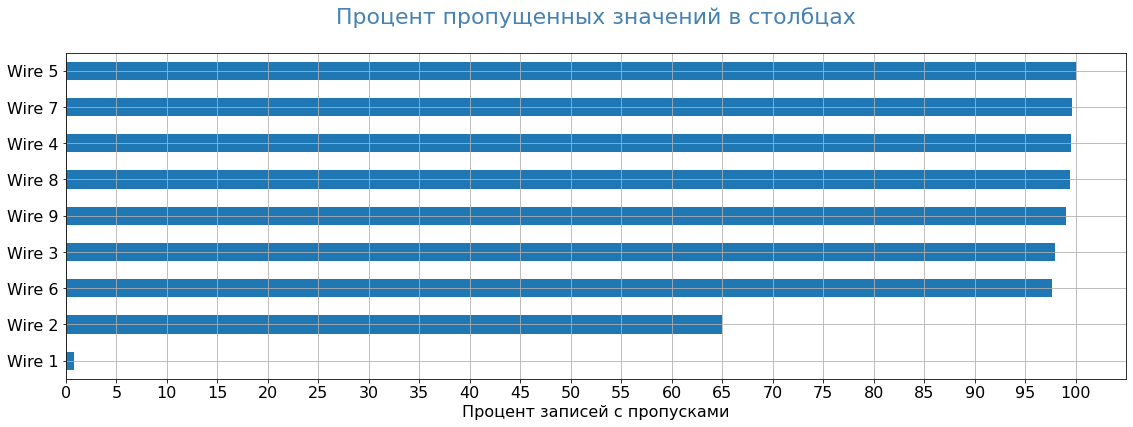

In [35]:
(data_wire.isna().mean()*100)\
.to_frame()\
.rename(columns = {0:'space'})\
.query('space > 0')\
.sort_values(by = 'space', ascending = True)\
.plot(kind = 'barh', figsize = (19,6), legend = False, fontsize = 16, grid=True)\
.set_title('Процент пропущенных значений в столбцах' + "\n", fontsize = 22, color = 'SteelBlue')
plt.xticks(range(0,105,5))
plt.xlabel('Процент записей с пропусками', fontsize=16);

**Вывод**

В данных о добавлении проволочных материалов много пропусков. Те столбцы, где пропусков более 95 проентов следует удалить. Остальные пропуски заполним нулями.

### 1.7 Данные о проволочных материалах (время)

In [36]:
data_wire_time.head(7)

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   
5    6  2019-05-03 13:57:27  2019-05-03 13:48:52    NaN    NaN    NaN    NaN   
6    7  2019-05-03 14:18:58                  NaN    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  
5    NaN    NaN    NaN  
6    NaN    NaN    NaN

In [37]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [38]:
data_wire_time.shape

(3081, 10)

In [39]:
data_wire_time.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

**Вывод**

Пропусков очень много, как и в объемах проволочных материалов, потому что пропуски означают, что материалы не использовали. Время подачи проволочных материалов не поможет нам в постоении моделей, эти данные не будут отнесены в признаки.

**Вопросы к заказчику: Можно ли поменять названия столбцов датафреймов или заказчику удобнее работать именно с такими названиями?**

## 2. Предобработка данных

### 2.1 Предобработка каждого датафрейма

#### 2.1.1 Данные об электродах

**Переименуем столбцы**

In [40]:
data_arc_columns = {
    'Начало нагрева дугой': 'start_arc_heating',
    'Конец нагрева дугой': 'finish_arc_heating',
    'Активная мощность': 'active_power',
    'Реактивная мощность': 'reactive_power',
}
data_arc = data_arc.rename(columns=data_arc_columns)

**Удалим партию с пропуском**

In [41]:
data_arc[data_arc['reactive_power'] <=0]

key    start_arc_heating   finish_arc_heating  active_power  \
9780  2116  2019-07-28 02:22:08  2019-07-28 02:23:57      0.705344   

      reactive_power  
9780     -715.479924

In [42]:
data_arc = data_arc[data_arc['key'] != 2116]

In [43]:
data_arc.describe()

key  active_power  reactive_power
count  14872.000000  14872.000000    14872.000000
mean    1615.085732      0.662753        0.487112
std      934.661090      0.258916        0.197623
min        1.000000      0.223120        0.153777
25%      806.000000      0.467114        0.337175
50%     1616.000000      0.599587        0.441667
75%     2429.000000      0.830314        0.608201
max     3241.000000      1.463773        1.270284

**Рассчитаем полную мощность**

In [44]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
data_arc.head()

key    start_arc_heating   finish_arc_heating  active_power  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02      0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33      0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36      0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19      0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37      0.867133   

   reactive_power  full_power  
0        0.211253    0.371123  
1        0.477438    0.902319  
2        0.430460    0.722536  
3        0.379979    0.642824  
4        0.643691    1.079934

**Рассчитаем время нагрева дугой**

In [45]:
data_arc['start_arc_heating'] = pd.to_datetime(data_arc['start_arc_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc['finish_arc_heating'] = pd.to_datetime(data_arc['finish_arc_heating'], format='%Y-%m-%d %H:%M:%S')

In [46]:
data_arc['time_arc_heating'] = data_arc['finish_arc_heating'] - data_arc['start_arc_heating']

In [47]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   key                 14872 non-null  int64          
 1   start_arc_heating   14872 non-null  datetime64[ns] 
 2   finish_arc_heating  14872 non-null  datetime64[ns] 
 3   active_power        14872 non-null  float64        
 4   reactive_power      14872 non-null  float64        
 5   full_power          14872 non-null  float64        
 6   time_arc_heating    14872 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), timedelta64[ns](1)
memory usage: 929.5 KB


In [48]:
data_arc.head()

key   start_arc_heating  finish_arc_heating  active_power  reactive_power  \
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253   
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438   
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460   
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979   
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691   

   full_power time_arc_heating  
0    0.371123  0 days 00:03:48  
1    0.902319  0 days 00:03:05  
2    0.722536  0 days 00:02:52  
3    0.642824  0 days 00:06:05  
4    1.079934  0 days 00:02:28

In [49]:
data_arc['time_arc_heating']= data_arc['time_arc_heating'].dt.seconds

**Рассчитаем энергию**

In [50]:
data_arc['energy'] = data_arc['time_arc_heating'] * data_arc['full_power']
data_arc.head()

key   start_arc_heating  finish_arc_heating  active_power  reactive_power  \
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253   
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438   
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460   
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979   
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691   

   full_power  time_arc_heating      energy  
0    0.371123               228   84.616003  
1    0.902319               185  166.928978  
2    0.722536               172  124.276277  
3    0.642824               365  234.630603  
4    1.079934               148  159.830252

**Просуммируем данные по ключу и выведем количество итераций обработки в каждой партии**

In [51]:
rounds = data_arc['key'].value_counts().reset_index(name='rounds').rename(columns={'index' : 'key'})
rounds.head()

key  rounds
0  2108      16
1  1689      15
2  1513      15
3  2567      14
4    46      13

In [52]:
data_arc = data_arc.groupby('key').sum()
data_arc.head()

active_power  reactive_power  full_power  time_arc_heating      energy
key                                                                        
1        3.036730        2.142821    3.718736              1098  770.282114
2        2.139408        1.453357    2.588349               811  481.760005
3        4.063641        2.937457    5.019223               655  722.837668
4        2.706489        2.056992    3.400038               741  683.455597
5        2.252950        1.687991    2.816980               869  512.169934

In [53]:
data_arc = data_arc.merge(rounds, on='key')
data_arc.head()

key  active_power  reactive_power  full_power  time_arc_heating  \
0    1      3.036730        2.142821    3.718736              1098   
1    2      2.139408        1.453357    2.588349               811   
2    3      4.063641        2.937457    5.019223               655   
3    4      2.706489        2.056992    3.400038               741   
4    5      2.252950        1.687991    2.816980               869   

       energy  rounds  
0  770.282114       5  
1  481.760005       4  
2  722.837668       5  
3  683.455597       4  
4  512.169934       4

Для сводной таблицы признаков оставим только энергию, количество итераций и ключ.

In [54]:
data_arc = data_arc[['key', 'energy', 'rounds']]
data_arc.head()

key      energy  rounds
0    1  770.282114       5
1    2  481.760005       4
2    3  722.837668       5
3    4  683.455597       4
4    5  512.169934       4

**Вывод**

Провели предобрабокту данных об электродах:
- Переименовали столбцы
- Удалили партию с пропуском
- Рассчитали полную мощность
- Рассчитали время нагрева дугой 
- Рассчитали энергию
- Посчитали количество итераций обработки в каждой партии
- Для сводной таблицы признаков оставили только ключ, энергию и количество итераций


#### 2.1.2 Данные о подаче сыпучих материалов (объем)

**Переименуем столбцы**

In [55]:
data_bulk_columns = {
    'Bulk 1': 'bulk_1',
    'Bulk 2': 'bulk_2',
    'Bulk 3': 'bulk_3',
    'Bulk 4': 'bulk_4',
    'Bulk 5': 'bulk_5',
    'Bulk 6': 'bulk_6',
    'Bulk 7': 'bulk_7',
    'Bulk 8': 'bulk_8',
    'Bulk 9': 'bulk_9',
    'Bulk 10': 'bulk_10',
    'Bulk 11': 'bulk_11',
    'Bulk 12': 'bulk_12',
    'Bulk 13': 'bulk_13',
    'Bulk 14': 'bulk_14',
    'Bulk 15': 'bulk_15',
}
data_bulk = data_bulk.rename(columns=data_bulk_columns)

**Удалим столбцы, где пропусков более 95 проентов**

In [56]:
data_bulk = data_bulk.drop(columns=['bulk_2', 'bulk_5', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_13'], axis=1)
data_bulk.head()

key  bulk_1  bulk_3  bulk_4  bulk_6  bulk_10  bulk_11  bulk_12  bulk_14  \
0    1     NaN     NaN    43.0     NaN      NaN      NaN    206.0    150.0   
1    2     NaN     NaN    73.0     NaN      NaN      NaN    206.0    149.0   
2    3     NaN     NaN    34.0     NaN      NaN      NaN    205.0    152.0   
3    4     NaN     NaN    81.0     NaN      NaN      NaN    207.0    153.0   
4    5     NaN     NaN    78.0     NaN      NaN      NaN    203.0    151.0   

   bulk_15  
0    154.0  
1    154.0  
2    153.0  
3    154.0  
4    152.0

**Заполним пропуски нулями**

In [57]:
data_bulk = data_bulk.fillna(0)
data_bulk.head()

key  bulk_1  bulk_3  bulk_4  bulk_6  bulk_10  bulk_11  bulk_12  bulk_14  \
0    1     0.0     0.0    43.0     0.0      0.0      0.0    206.0    150.0   
1    2     0.0     0.0    73.0     0.0      0.0      0.0    206.0    149.0   
2    3     0.0     0.0    34.0     0.0      0.0      0.0    205.0    152.0   
3    4     0.0     0.0    81.0     0.0      0.0      0.0    207.0    153.0   
4    5     0.0     0.0    78.0     0.0      0.0      0.0    203.0    151.0   

   bulk_15  
0    154.0  
1    154.0  
2    153.0  
3    154.0  
4    152.0

**Вывод**

Провели предобработку данных об объеме подаче сыпучих материалов:
- Переименовали столбцы 
- Удалили столбцы, где пропусков более 95 проентов
- Остальные пропуски заполнили нулями


#### 2.1.3 Данные о продувке сплава газом

**Переименуем столбцы**

In [58]:
data_gas = data_gas.rename(columns={'Газ 1' : 'gas_1'})
data_gas.head()

key      gas_1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

In [59]:
data_gas.shape

(3239, 2)

#### 2.1.4 Результаты измерения температуры

**Переименуем столбцы**

In [60]:
data_temp = data_temp.rename(columns={'Время замера' : 'timestamp', 'Температура' : 'temperature'})
data_temp.head()

key            timestamp  temperature
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

In [61]:
data_temp.shape

(18092, 3)

**Удалим партии c пропусками и одним значением в партии**

In [62]:
keys_drop = data_temp[data_temp['temperature'].isna()]['key'].unique()

In [63]:
data_temp = data_temp[~data_temp['key'].isin(keys_drop)]
data_temp.shape

(13926, 3)

In [64]:
keys_drop_2 = data_temp[data_temp['temperature'] < 1450]['key']

In [65]:
data_temp = data_temp[~data_temp['key'].isin(keys_drop_2)]
data_temp.shape

(13905, 3)

In [66]:
data_temp.groupby('key')['key'].count().sort_values()

key
279      1
195      1
614      2
1268     2
1974     2
        ..
46      14
322     14
1689    16
1513    16
2108    17
Name: key, Length: 2473, dtype: int64

In [67]:
data_temp = data_temp[~data_temp['key'].isin([279, 195])]
data_temp.shape

(13903, 3)

**Оставим данные только с первых и последних замеров в каждой партии, посчитаем время замера каждой партии**

In [68]:
data_temp['timestamp'] = pd.to_datetime(data_temp['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [69]:
data_temp = data_temp.groupby('key').agg(["first", "last"]).reset_index()
data_temp.columns = ['key', 'first_temp_ts', 'last_temp_ts', 'first_temp', 'last_temp']
data_temp['time_temp_ts'] = data_temp['last_temp_ts']-data_temp['first_temp_ts']
data_temp['time_temp_ts']= data_temp['time_temp_ts'].dt.seconds
data_temp.head()

key       first_temp_ts        last_temp_ts  first_temp  last_temp  \
0    1 2019-05-03 11:02:04 2019-05-03 11:30:38      1571.0     1613.0   
1    2 2019-05-03 11:34:04 2019-05-03 11:55:09      1581.0     1602.0   
2    3 2019-05-03 12:06:44 2019-05-03 12:35:57      1596.0     1599.0   
3    4 2019-05-03 12:39:27 2019-05-03 12:59:47      1601.0     1625.0   
4    5 2019-05-03 13:11:03 2019-05-03 13:36:39      1576.0     1602.0   

   time_temp_ts  
0          1714  
1          1265  
2          1753  
3          1220  
4          1536

In [70]:
data_temp = data_temp[['key', 'first_temp', 'last_temp', 'time_temp_ts']]
data_temp.head()

key  first_temp  last_temp  time_temp_ts
0    1      1571.0     1613.0          1714
1    2      1581.0     1602.0          1265
2    3      1596.0     1599.0          1753
3    4      1601.0     1625.0          1220
4    5      1576.0     1602.0          1536

In [71]:
data_temp.shape

(2471, 4)

**Вывод**

Провели предобработку данных о результатах измерения температуры:
- Переименовали столбцы
- Удалили партии с пропусками и с одним значением в партии
- Удалили партии с температурой менее 1450 градусов
- Для итоговой таблицы оставили данные  только о первых и последних замеров в каждой партии, время замера каждой партии


#### 2.1.5 Данные о проволочных материалах (объем)

**Переименуем столбцы**

In [72]:
data_wire_columns = {
    'Wire 1': 'wire_1',
    'Wire 2': 'wire_2',
    'Wire 3': 'wire_3',
    'Wire 4': 'wire_4',
    'Wire 5': 'wire_5',
    'Wire 6': 'wire_6',
    'Wire 7': 'wire_7',
    'Wire 8': 'wire_8',
    'Wire 9': 'wire_9',
    
}
data_wire = data_wire.rename(columns=data_wire_columns)
data_wire.head()

key     wire_1   wire_2  wire_3  wire_4  wire_5  wire_6  wire_7  wire_8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   wire_9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

**Удалим столбцы, где пропусков более 95 проентов**

In [73]:
data_wire = data_wire[['key', 'wire_1', 'wire_2']]
data_wire.head()

key     wire_1   wire_2
0    1  60.059998      NaN
1    2  96.052315      NaN
2    3  91.160157      NaN
3    4  89.063515      NaN
4    5  89.238236  9.11456

**Заполним пропуски нулями**

In [74]:
data_wire = data_wire.fillna(0)
data_wire.head()

key     wire_1   wire_2
0    1  60.059998  0.00000
1    2  96.052315  0.00000
2    3  91.160157  0.00000
3    4  89.063515  0.00000
4    5  89.238236  9.11456

In [75]:
data_wire.shape

(3081, 3)

**Вывод**

Провели предобработку данных о проволочных материалах:
- Переименовали столбцы 
- Удалили столбцы, где пропусков более 95 проентов
- Остальные пропуски заполнили нулями

### 2.2 Сводная таблица

#### 2.2.1 Объединие данных в одну таблицу

In [76]:
data_full = data_arc.merge(data_bulk, on='key', how='inner')
data_full = data_full.merge(data_gas, on='key', how='inner')
data_full = data_full.merge(data_temp, on='key', how='inner')
data_full = data_full.merge(data_wire, on='key', how='inner')
data_full.head()

key      energy  rounds  bulk_1  bulk_3  bulk_4  bulk_6  bulk_10  bulk_11  \
0    1  770.282114       5     0.0     0.0    43.0     0.0      0.0      0.0   
1    2  481.760005       4     0.0     0.0    73.0     0.0      0.0      0.0   
2    3  722.837668       5     0.0     0.0    34.0     0.0      0.0      0.0   
3    4  683.455597       4     0.0     0.0    81.0     0.0      0.0      0.0   
4    5  512.169934       4     0.0     0.0    78.0     0.0      0.0      0.0   

   bulk_12  bulk_14  bulk_15      gas_1  first_temp  last_temp  time_temp_ts  \
0    206.0    150.0    154.0  29.749986      1571.0     1613.0          1714   
1    206.0    149.0    154.0  12.555561      1581.0     1602.0          1265   
2    205.0    152.0    153.0  28.554793      1596.0     1599.0          1753   
3    207.0    153.0    154.0  18.841219      1601.0     1625.0          1220   
4    203.0    151.0    152.0   5.413692      1576.0     1602.0          1536   

      wire_1   wire_2  
0  60.059998  0.00000  
1  96.052315  0.00000  
2  91.160157  0.00000  
3  89.063515  0.00000  
4  89.238236  9.11456

In [77]:
data_full.isna().sum()

key             0
energy          0
rounds          0
bulk_1          0
bulk_3          0
bulk_4          0
bulk_6          0
bulk_10         0
bulk_11         0
bulk_12         0
bulk_14         0
bulk_15         0
gas_1           0
first_temp      0
last_temp       0
time_temp_ts    0
wire_1          0
wire_2          0
dtype: int64

In [78]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           2324 non-null   int64  
 1   energy        2324 non-null   float64
 2   rounds        2324 non-null   int64  
 3   bulk_1        2324 non-null   float64
 4   bulk_3        2324 non-null   float64
 5   bulk_4        2324 non-null   float64
 6   bulk_6        2324 non-null   float64
 7   bulk_10       2324 non-null   float64
 8   bulk_11       2324 non-null   float64
 9   bulk_12       2324 non-null   float64
 10  bulk_14       2324 non-null   float64
 11  bulk_15       2324 non-null   float64
 12  gas_1         2324 non-null   float64
 13  first_temp    2324 non-null   float64
 14  last_temp     2324 non-null   float64
 15  time_temp_ts  2324 non-null   int64  
 16  wire_1        2324 non-null   float64
 17  wire_2        2324 non-null   float64
dtypes: float64(15), int64(3)
mem

#### 2.2.2 Корреляция данных

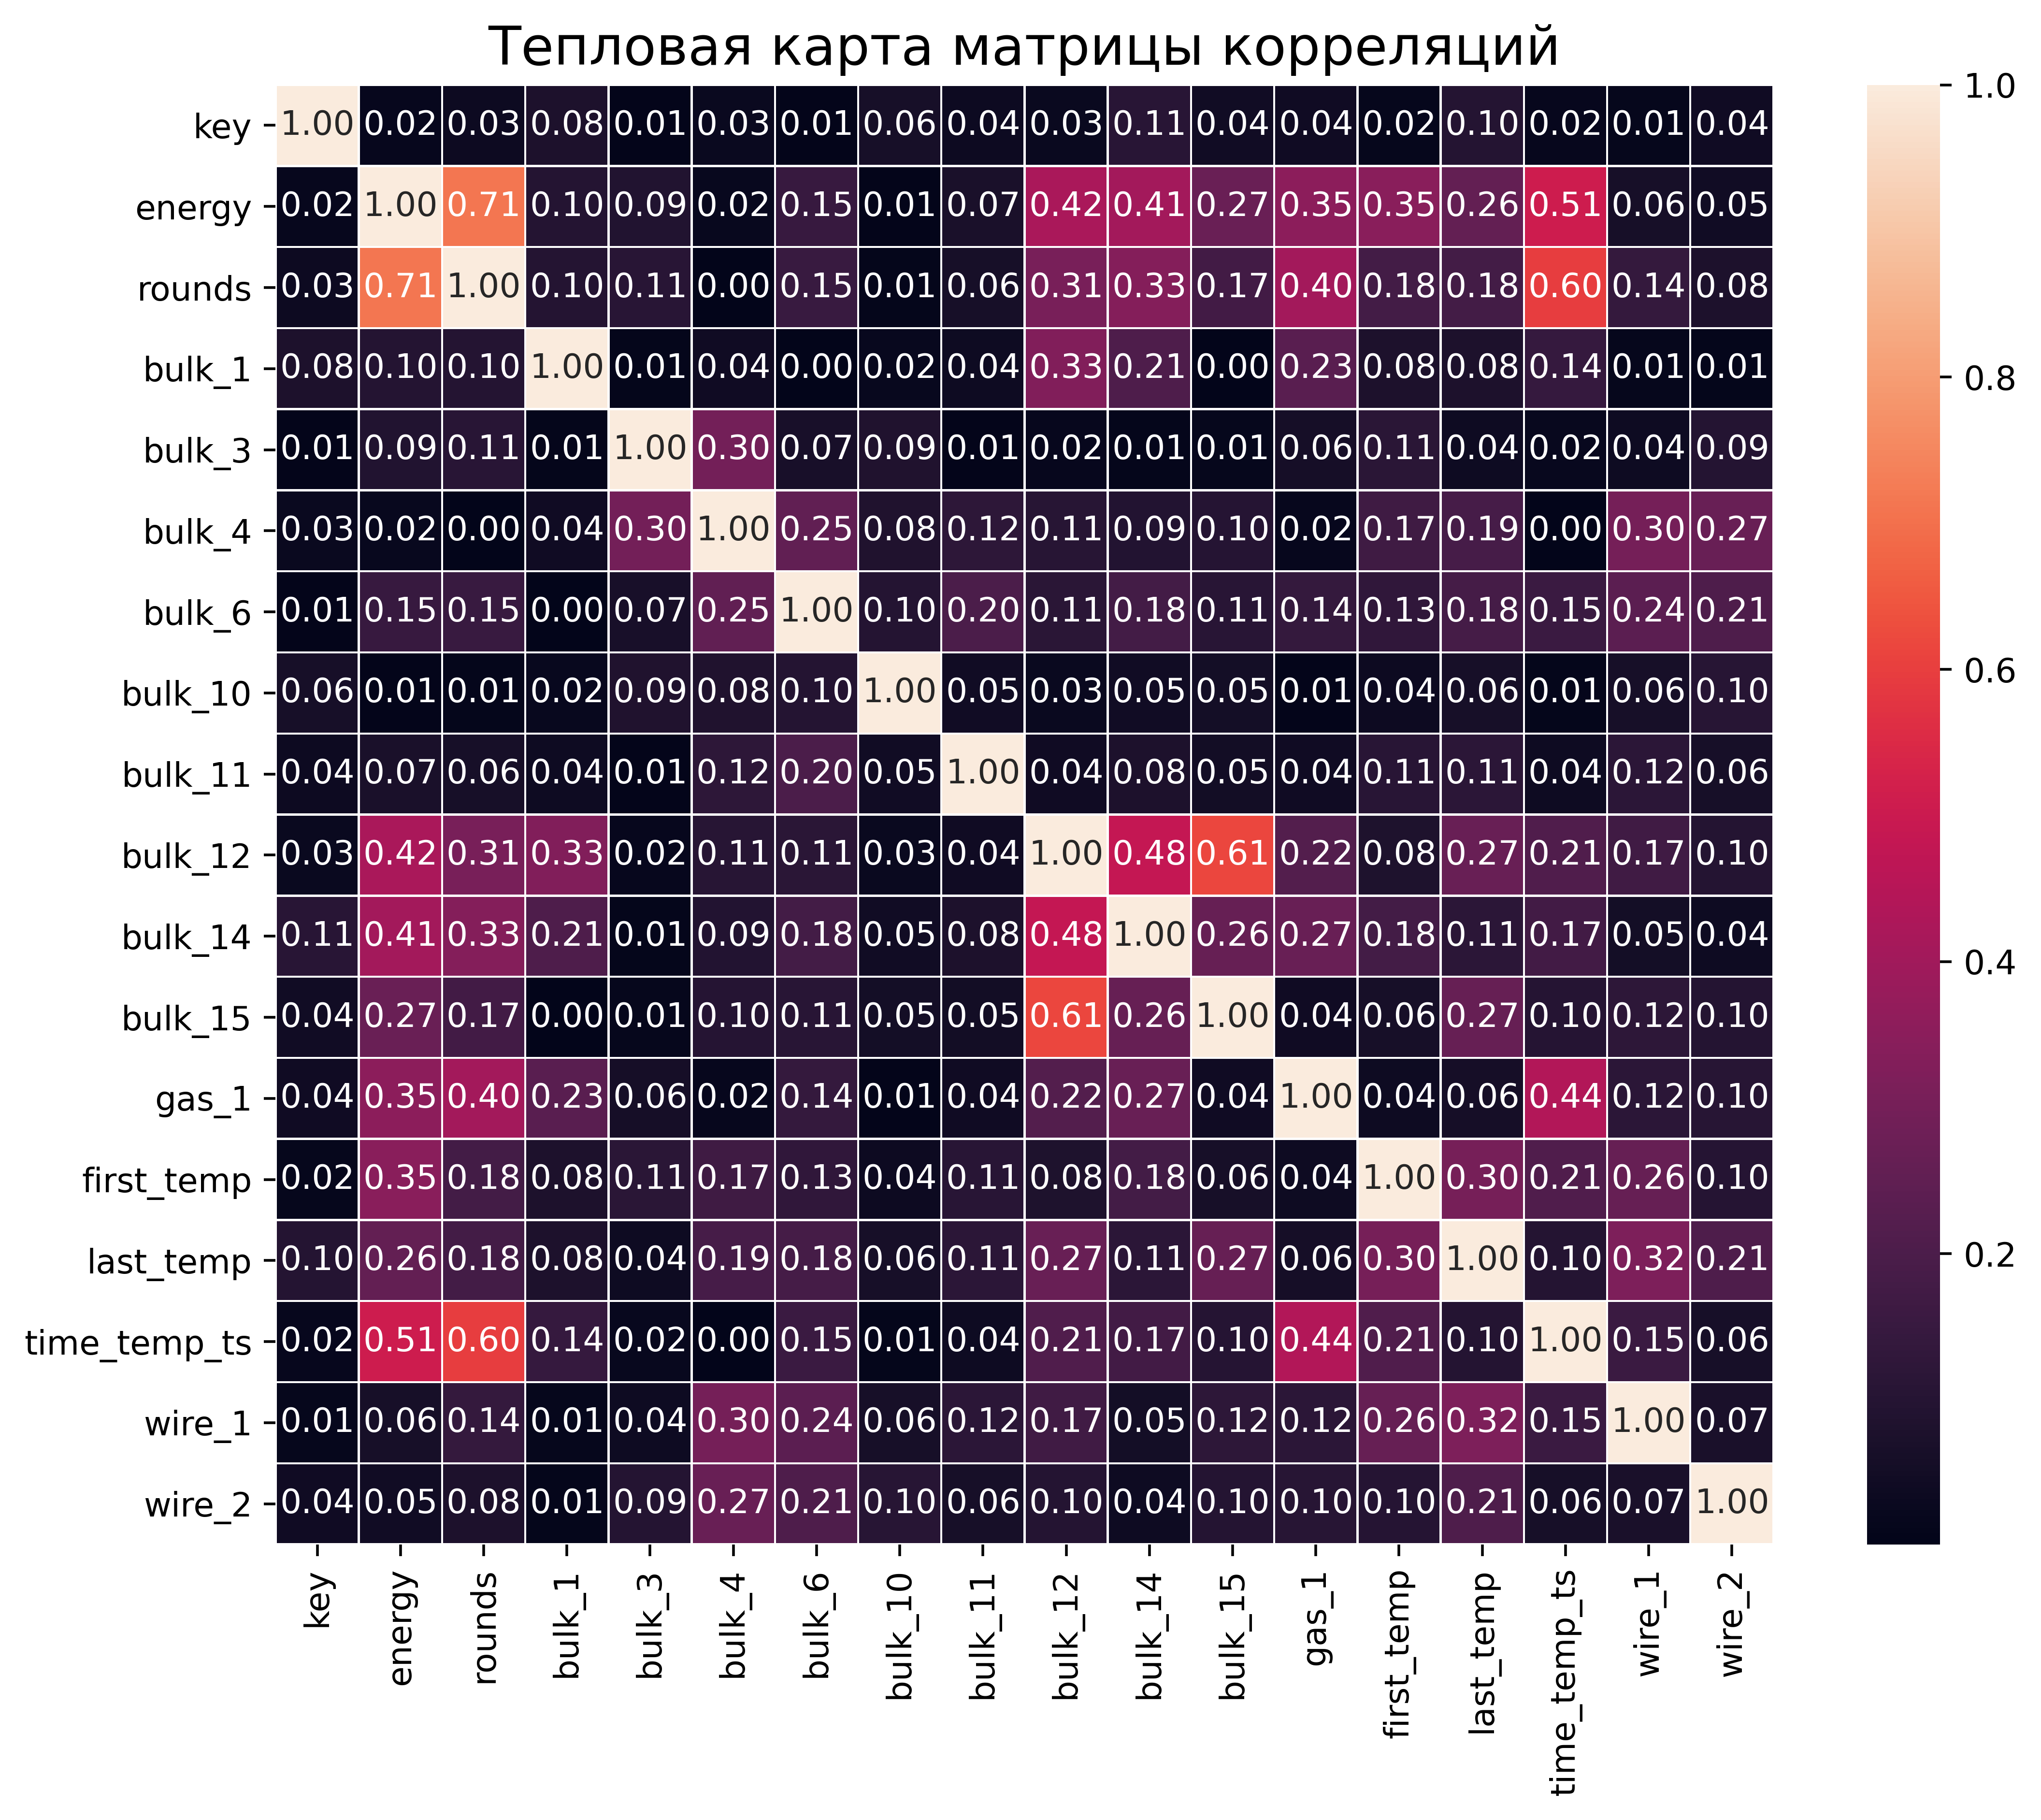

In [79]:
plt.figure(figsize=(10,8), dpi =500)
sns.heatmap(data_full.corr().abs(),annot=True,fmt=".2f", linewidth=.5)
plt.title('Тепловая карта матрицы корреляций', fontsize=16)
plt.show()

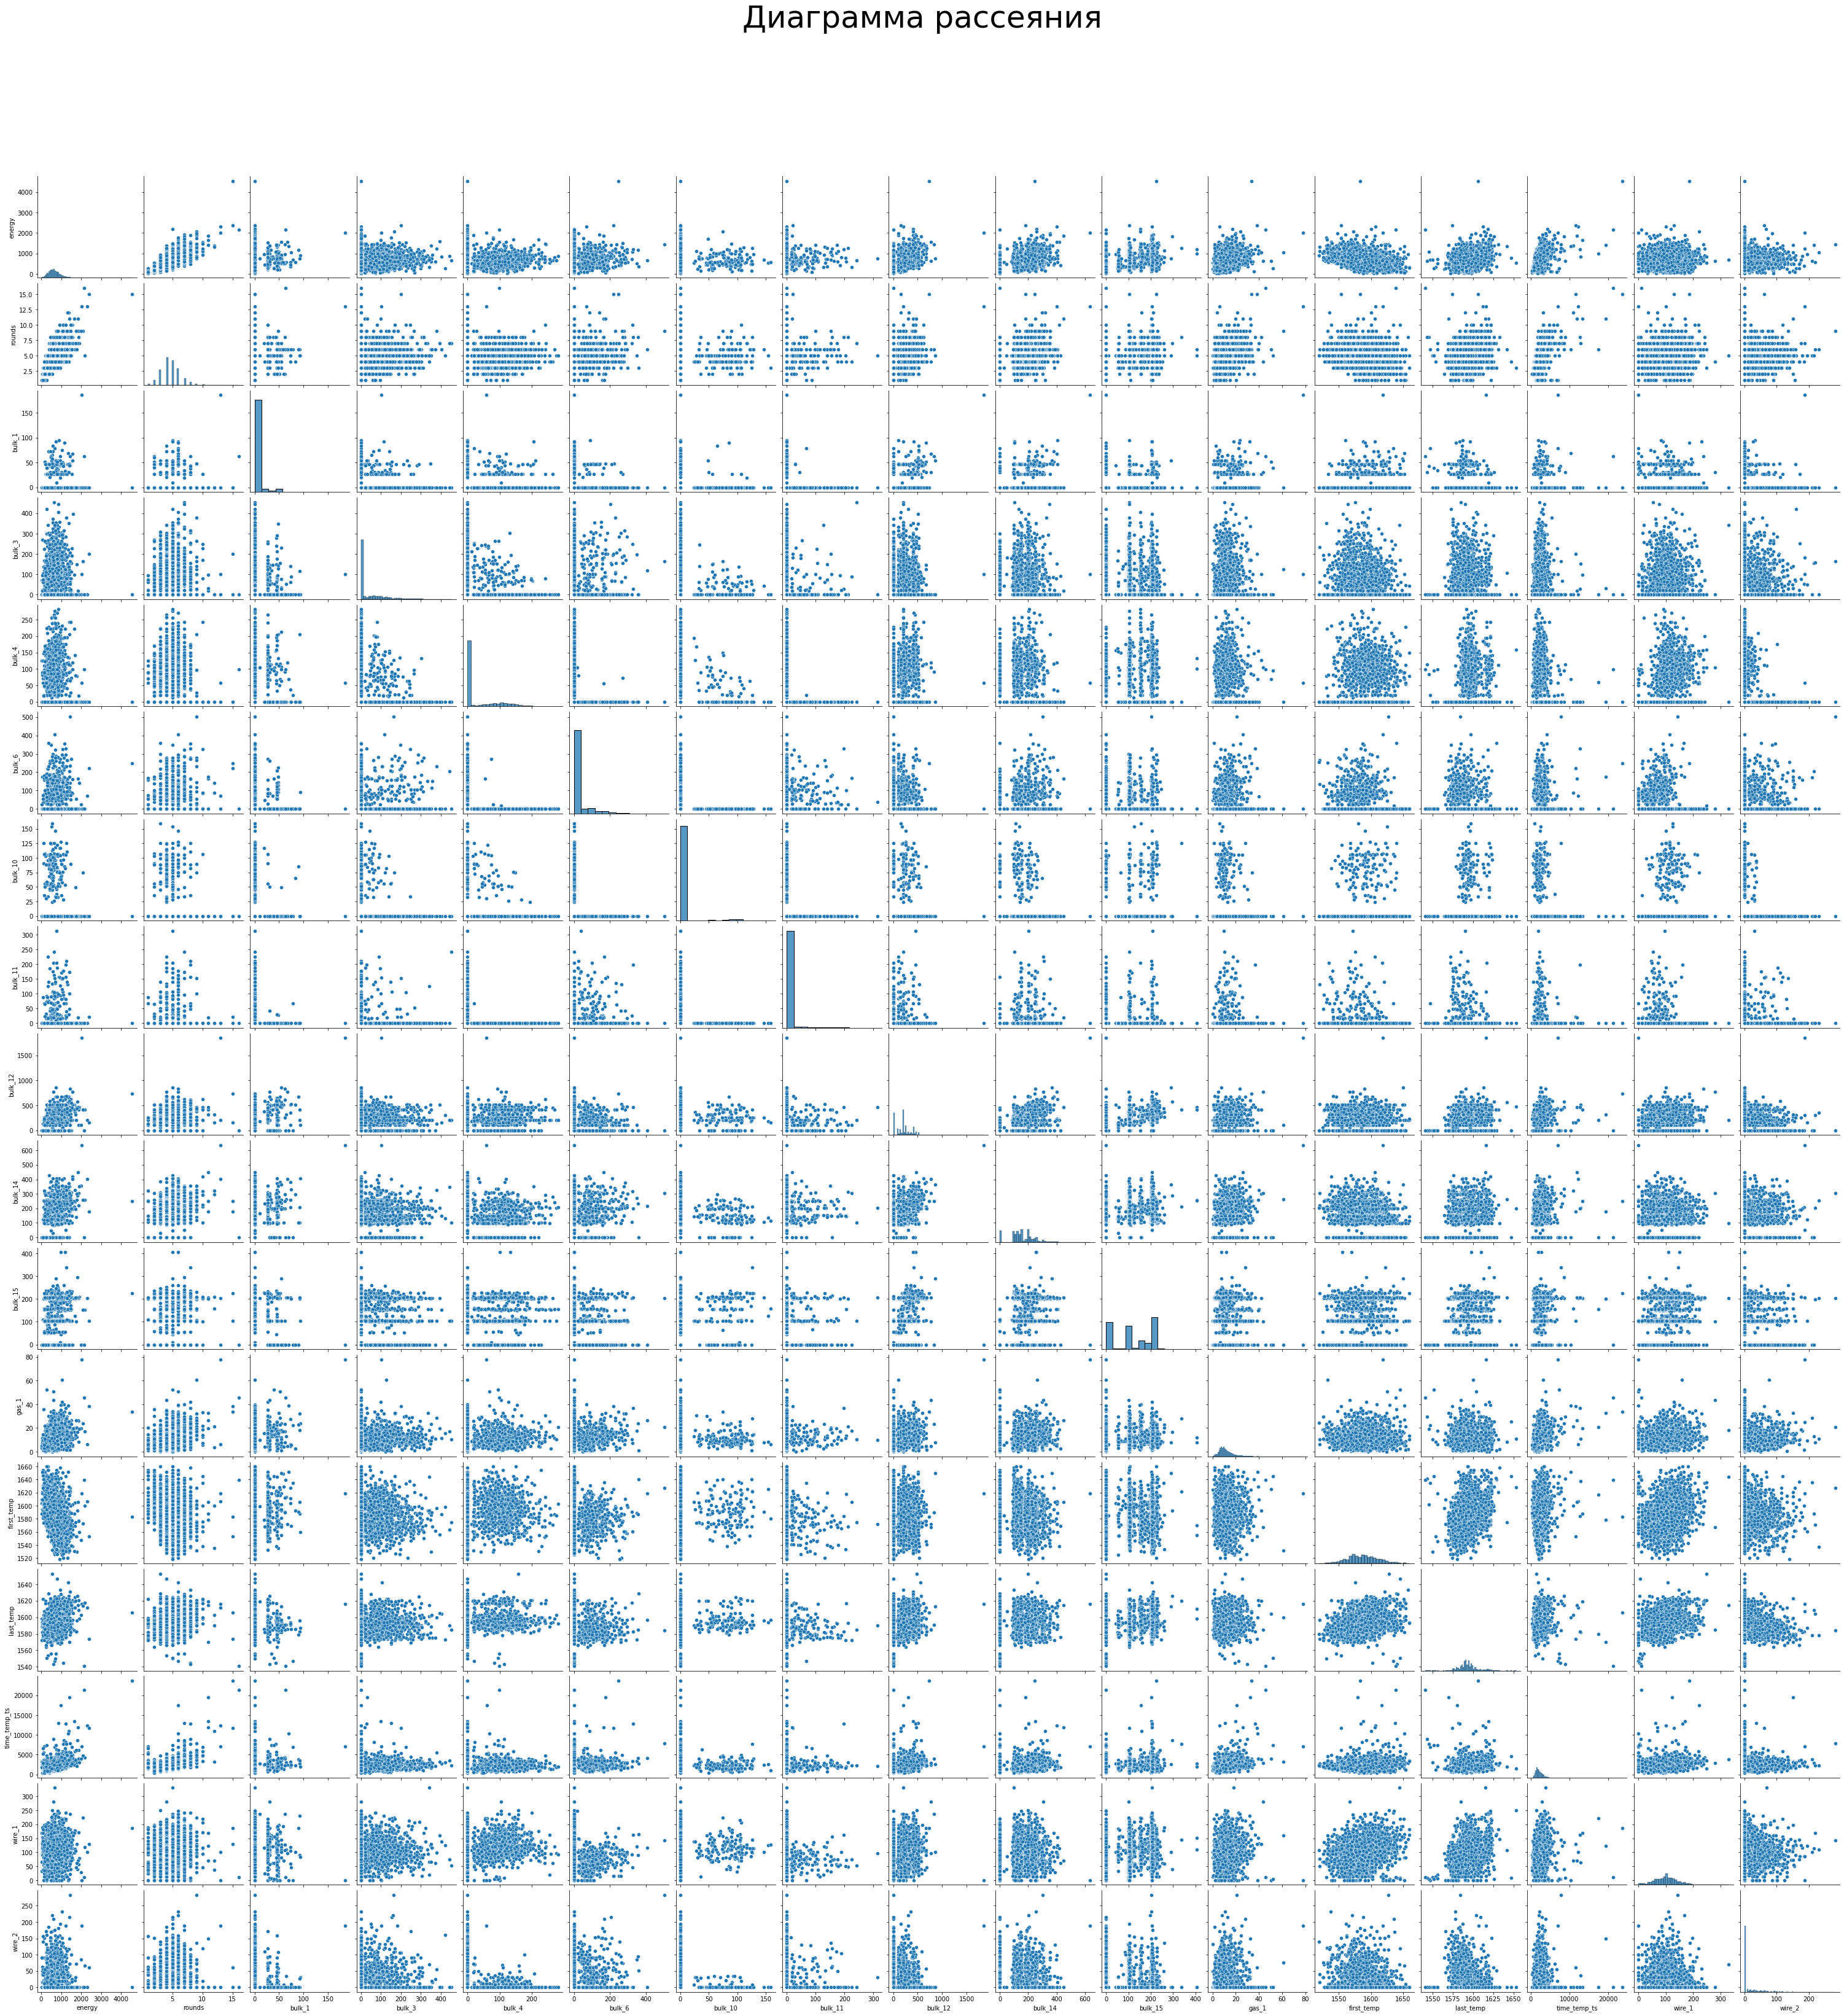

In [80]:
sns.pairplot(data=data_full.drop(['key'], axis=1)).fig.suptitle("Диаграмма рассеяния", fontsize=50, y=1.08);

Высокая корреляция признаков не наблюдаются. Данные отлично подходят для построения моделей.

**Исследуем признаки полученного датафрейма**

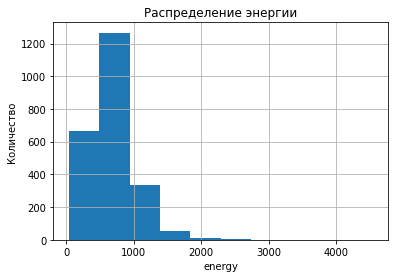

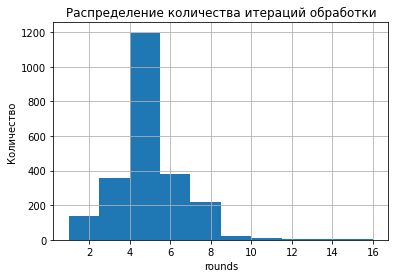

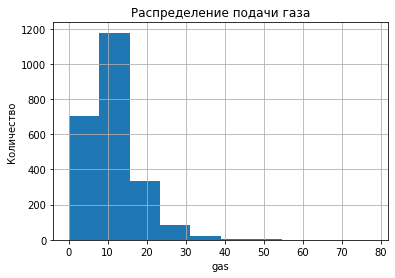

In [81]:
data_full['energy'].hist()
plt.title('Распределение энергии')
plt.xlabel('energy')
plt.ylabel('Количество')
plt.show()
data_full['rounds'].hist()
plt.title('Распределение количества итераций обработки')
plt.xlabel('rounds')
plt.ylabel('Количество')
plt.show()
data_full['gas_1'].hist()
plt.title('Распределение подачи газа')
plt.xlabel('gas')
plt.ylabel('Количество')
plt.show()

По графикам распределения можно определить пики: энергия - 500, количество итераций 4 и 5, подача газа от 10 до 15.

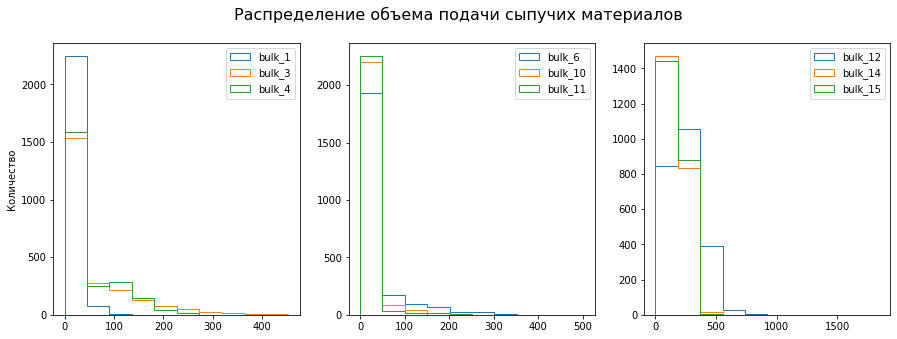

In [82]:
fig, axes = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle(f'Распределение объема подачи сыпучих материалов', fontsize = 16)
data_full[['bulk_1', 'bulk_3', 'bulk_4']].plot(kind='hist', ax = axes[0], histtype='step').set_ylabel('Количество')
data_full[['bulk_6', 'bulk_10', 'bulk_11']].plot(kind='hist', ax = axes[1], histtype='step').set_ylabel('')
data_full[['bulk_12', 'bulk_14', 'bulk_15']].plot(kind='hist', ax = axes[2], histtype='step').set_ylabel('')

plt.show()

В основном сыпучие материалы подаются объемом от 0 до 50.

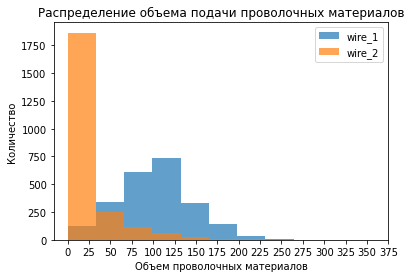

In [83]:
data_full[['wire_1', 'wire_2']].plot(kind='hist', alpha=0.7)
plt.title(f'Распределение объема подачи проволочных материалов')
plt.xlabel('Объем проволочных материалов')
plt.ylabel('Количество')
plt.xticks(range(0,400, 25))
plt.show()

Пик объема подачи проволочных материалов от 0 до 25.

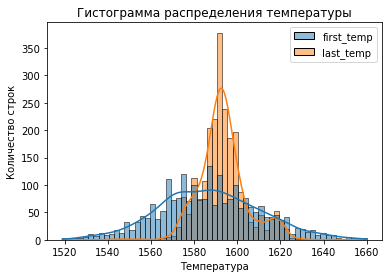

In [84]:
temp_hist = sns.histplot(data=data_full[['first_temp', 'last_temp']], kde=True)
temp_hist.set_ylabel('Количество строк')
temp_hist.set_xlabel('Температура')
temp_hist.set_title('Гистограмма распределения температуры');

Конечная температура, в основном, намного выше первой. Пик конечной температуры в районе 1590 градусов 

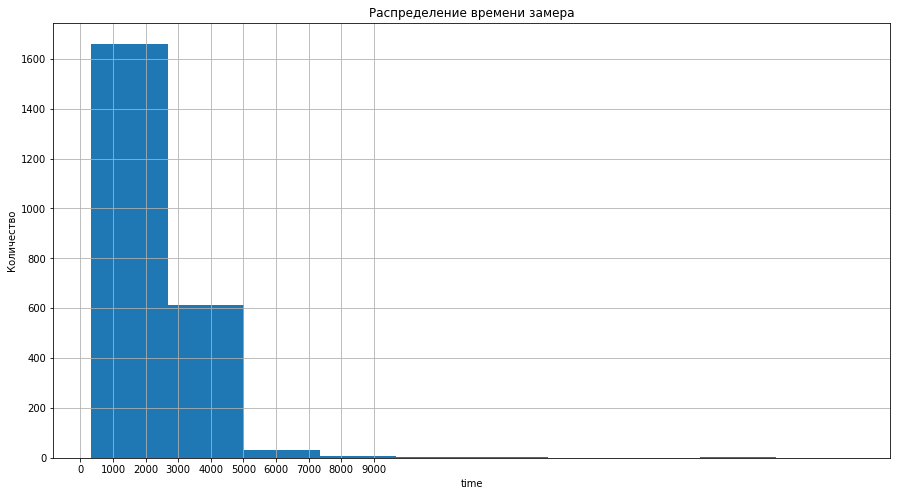

In [85]:
plt.figure(figsize=(15,8))
data_full['time_temp_ts'].hist()

plt.title('Распределение времени замера')
plt.xlabel('time')
plt.ylabel('Количество')
plt.xticks(range(0,10000, 1000))

plt.show()

В основном время замера проводится от 500 до 3000 секунд.

### 2.3 Разделим датафрейм на выборки

**Разделим датафрйм на признаки и целевой признак**

In [86]:
target = data_full['last_temp']
features = data_full.drop(['last_temp', 'key'], axis=1)
target.shape, features.shape

((2324,), (2324, 16))

In [87]:
RANDOM_STATE=110923

In [88]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

**Вывод**

Провели предобработку данных каждого датафреймя. В сводную таблицу вошли столбцы: 'key', 'energy', 'rounds', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'gas_1',
       'first_temp', 'last_temp', 'time_temp_ts', 'wire_1', 'wire_2'.
       
Проверили корреляцию данных. Данные отлично подходят для построения моделей.

Разделили данные на признаки и целевой признак, на тестовую и обучающую выборки.

## 3. Разработка моделей

### 3.1 Обучение моделей

#### 3.1.1 LinearRegression

In [89]:
%%time
model_LR = LinearRegression()
lr = make_pipeline(StandardScaler(),model_LR)
lr_params = {'linearregression__normalize':[False]} 
grid = GridSearchCV(lr, param_grid=lr_params, scoring='neg_mean_absolute_error')
grid.fit(features_train, target_train)

MAE_lr = abs(grid.best_score_)

print('MAE для линейной регрессии -', MAE_lr)

MAE для линейной регрессии - 6.435885795886034
Wall time: 306 ms


#### 3.1.2 CatBoostRegressor

In [90]:
%%time
model_CR = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
parameters = {
             'learning_rate':[0.05],
             'max_depth': range(2, 8),
             'n_estimators':[500]}
cat_grid = GridSearchCV(estimator=model_CR, param_grid=parameters, cv=5, scoring='neg_mean_absolute_error')
cat_grid.fit(features_train, target_train)
MAE_Cr = abs(cat_grid.best_score_)

print('MAE для линейной регрессии -', MAE_Cr)
print(cat_grid.best_params_)


MAE для линейной регрессии - 6.232531892124533
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Wall time: 1min 13s


#### 3.1.3 RandomForestRegressor

In [91]:
%%time
model_RF = RandomForestRegressor(random_state=RANDOM_STATE)
RF = make_pipeline(StandardScaler(),model_RF)
param_search = {'randomforestregressor__n_estimators': range(1, 42, 10),
                'randomforestregressor__max_depth': range(2, 15)}
grid_RF = GridSearchCV(RF, param_grid=param_search, scoring='neg_mean_absolute_error')
grid_RF.fit(features_train, target_train)

MAE_RF = abs(grid_RF.best_score_)

print('MAE для линейной регрессии -', MAE_RF)
print(grid_RF.best_params_)


MAE для линейной регрессии - 6.476407092499963
{'randomforestregressor__max_depth': 7, 'randomforestregressor__n_estimators': 41}
Wall time: 1min 56s


МАЕ всех трех моделей меньше необходимой. Лучший результат у CatBoostRegressor, ее и выберем для проверки на тестовой выборке.

### 3.2 Проверка лучшей модели на тестовой выборке

In [92]:
predictions_test = cat_grid.predict(features_test)
result = mean_absolute_error(target_test, predictions_test)

print("MAE модели CatBoostRegressor на тестовой выборке:", round(result, 2))

MAE модели CatBoostRegressor на тестовой выборке: 6.64


МАЕ менее 6.8. Данную модель можно рекомендовать для предсказания температуры стали.

### 3.3 Проверка модели на адекватность

In [93]:
dummy_r = DummyRegressor()
dummy_r.fit(features_train, target_train)
predict = dummy_r.predict(features_test)   
MAE_dummy = mean_absolute_error(target_test, predict)   
print('MAE -', MAE_dummy)

MAE - 8.16165374554526


Константная модель показала результаты хуже, чем наша, что говорит о ее адекватности.

### 3.4 Исследование важности признаков

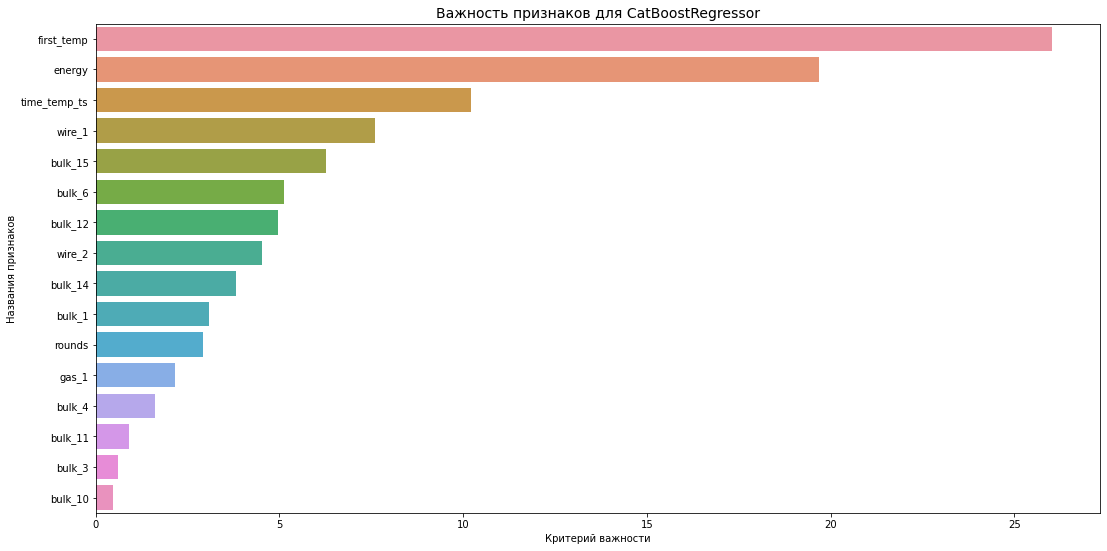

In [94]:
plot_data = {
    'features': features_test.columns,
    'feature_importances': cat_grid.best_estimator_.feature_importances_
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для CatBoostRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

Самые важные признаки: first_temp, energy, time_temp_ts. А признаки bulk_11, bulk_3, bulk_10 меньше всего влияют на качество модели

**Удалим неважные признаки и посмотрим на результат**

In [95]:
model = CatBoostRegressor(random_state=RANDOM_STATE, 
                          verbose=False, 
                          learning_rate=0.05, 
                          max_depth=3, 
                          n_estimators=500)
model.fit(features_train.drop(['bulk_11', 'bulk_3', 'bulk_10'], axis=1), target_train)
predictions_test = model.predict(features_test.drop(['bulk_11', 'bulk_3', 'bulk_10'], axis=1))
result = mean_absolute_error(target_test, predictions_test)

print("MAE модели CatBoostRegressor на тестовой выборке:", round(result, 2))

MAE модели CatBoostRegressor на тестовой выборке: 6.64


Результат не изменился, а значит эти признаки можно удалить

**Вывод по предобработке данных и построению модели**

- Привёла названия столбцов к стандартному виду
- Обработала пропуски и аномальные значения
- Убрала признаки, по которым было совсем незначительное количество данных по партиям
- Добавила дополнительные признаки (энергия, количество итераций обработки в каждой партии, время замера каждой партии)
- Для сводной таблицы оставила данные: 'key', 'energy', 'rounds', 'bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15', 'gas_1', 'first_temp', 'last_temp', 'time_temp_ts', 'wire_1', 'wire_2'
- Построила таблицу корреляцию признаков и диаграмму рассеяния, по которой определила, что все данные подходят для обучения модели
- Исследовала признаки полученного датафрейма
- Разделила финальный датафрейм на выборки, на признаки и целевой признак
- Обучила 3 модели: LinearRegression, RandomForestRegressor, CatBoostRegressor. Лучший результат показала модель CatBoostRegressor. Проверила на тестовой выборке: МАЕ менее 6.8. Данную модель можно рекомендовать для предсказания температуры стали.Проверила модель на адекватность.
- Исследовала важность признаков. Самые важные признаки: first_temp, energy, time_temp_ts. А признаки bulk_11, bulk_3, bulk_10 меньше всего влияют на качество модели. Проверили качетсво модели без неважных признаков. Результат не изменился, значит они не нужны для построения модели

## 4. Отчет

### 4.1 Сравнение решения и плана, если есть отклонение - объясняем почему

Все пункты были выполнены. Масштабирование было решено проводить во время обучения модели используя pipeline

### 4.2 Описание трудностей проекта (и как они были решены)

На этапе знакомства с данными было сложно понять, что они означают, какие данные подойдут для обучения модели, почему такое количество пропусков и что с ними делать. После встречи с тимлидом Дмитрием появилось понимание, как выполнять проект.

### 4.3 Описание ключевых шагов решения

#### 4.3.1 Подготовка данных (склейка, предобработка)

Данные каждого датафрейма были загружены и изучены. Была проведена предобработка. В данных об электродах и температуре были удалены партии с пропусками. В данных о подаче материалов были удалены партии, где пропусков более 95%, остальные пропуски были заменены нулями. 

- в данных об электродах: Рассчитали энергию (полная мощность умножить на время нагрева дугой). Посчитали количество итераций обработки в каждой партии, просуммировали данные по ключу.
- в данных о результатах измерения температуры: Удалили партию с одним значением, партии с температурой менее 1450 градусов. Посчитали время замера каждой партии. Оставили только первую и последнюю температуру каждой партии.

Данные объединили в сводную таблицу по ключу.


#### 4.3.2 Обучение моделей, выбор лучшей и её тестирование

Было обучено 3 модели, выбрана та, где метрика МАЕ наименьшая. Это CatBoostRegressor. Ее протестировали и проверили на адекватность.

### 4.4 Признаки, которые использовали для обучения и их предобработка

Целевой признак – последняя температура в каждой партии ('last_temp').

Признаки: энергия ('energy'), количество итераций обработки ('rounds'),  объем подачи сыпучих материалов ('bulk_1', 'bulk_3', 'bulk_4', 'bulk_6', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_14', 'bulk_15'), продувка сплава газом ('gas_1'), начальная температура каждой партии ('first_temp'), время замера каждой партии ('time_temp_ts'), объем подачи проволочных материалов ('wire_1', 'wire_2').


Таблица корреляции признаков и диаграмма рассеяния показали, что все данные подходят для обучения модели

### 4.5 Полное описание модели (с гиперпараметрами, включая random_state, если использовался)

Выбранна модель CatBoostRegressor с гиперпараметрами:
- random_state= 110923, 
- verbose=False, 
- learning_rate=0.05,
 - max_depth=3, 
- n_estimators=500


### 4.6 Итоговая метрика

MAE модели CatBoostRegressor на тестовой выборке: 6.64

MAE (Mean absolute error) - средняя абсолютная ошибка, то есть показатель того, насколько градусов модель ошибается при расчете, соотвественно, чем меньше ошибка, тем лучше работает модель. 

### 4.7 Рекомендации по улучшению решения

Допускаю, что можно улучшить результат за счёт лучшего подбора параметров, можно попробовать для обучения другие модели. Так же можно попробовать убрать признаки с достаточно высокой корреляцией.